<a href="https://www.kaggle.com/isaell/travel-customer-churn-analysis-prediction?scriptVersionId=88098284" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Objective

**Predict customer churn for tour and travels company based on customer data. What are the key indicators of customer churn?**

# Main results summary:

The key indicators of customer churn were age, frequent flyer status and income class. Specifically, 

 * younger customers (27-28y) tend to churn proportionally more often
 * frequent flyers churn more than non-frequent flyers   
 * high income individuals churn more than low and middle income classes  

Of the compared models, the balanced bagging classifier performed best in order to predict customer churn. It performed with an overall accuracy of 90%, as well as an F1 score 81 and other performance metrics >70 for the minority class. Given that it may be most important to correctly identify those customers who churn, the priority is to predict the minority class correctly. Thus, using a classifier focusing on balancing the data set and therefore boosting performance to identify those customers who churn, so they can be in focus of measures to improve customer satisfaction.  

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# data pre-processing 
from sklearn.preprocessing import StandardScaler, LabelEncoder

# models
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier 

# model selection and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# import data
df = pd.read_csv('../input/tour-travels-customer-churn-prediction/Customertravel.csv')
df.head() 

,Age,FrequentFlyer,AnnualIncomeClass,ServicesOpted,AccountSyncedToSocialMedia,BookedHotelOrNot,Target
0,34,No,Middle Income,6,No,Yes,0
1,34,Yes,Low Income,5,Yes,No,1
2,37,No,Middle Income,3,Yes,No,0
3,30,No,Middle Income,2,No,No,0
4,30,No,Low Income,1,No,No,0


In [3]:
# rename churn column for clarity
df.rename(columns={'Target': 'Churn'}, inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 954 entries, 0 to 953
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Age                         954 non-null    int64 
 1   FrequentFlyer               954 non-null    object
 2   AnnualIncomeClass           954 non-null    object
 3   ServicesOpted               954 non-null    int64 
 4   AccountSyncedToSocialMedia  954 non-null    object
 5   BookedHotelOrNot            954 non-null    object
 6   Churn                       954 non-null    int64 
dtypes: int64(3), object(4)
memory usage: 52.3+ KB


# Exploratory Data Analysis

In [5]:
df.groupby('Churn').describe()

Age                                                    ServicesOpted  \
       count       mean       std   min   25%   50%   75%   max         count   
Churn                                                                           
0      730.0  32.352055  3.209323  27.0  30.0  31.0  35.0  38.0         730.0   
1      224.0  31.316964  3.620133  27.0  28.0  30.0  35.0  38.0         224.0   

                                                    
           mean       std  min  25%  50%  75%  max  
Churn                                               
0      2.402740  1.554495  1.0  1.0  2.0  3.0  6.0  
1      2.549107  1.763430  1.0  1.0  2.0  4.0  6.0

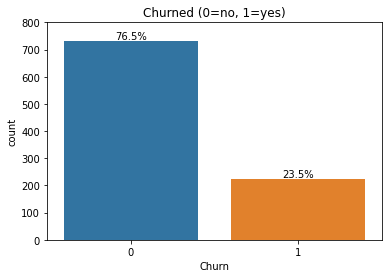

In [6]:
ax = sns.countplot(data=df, x='Churn')
percentage = df['Churn'].value_counts(normalize=True).values * 100
lbls = [f'{p:.1f}%' for p in percentage]

ax.bar_label(container=ax.containers[0], labels=lbls)   
plt.ylim(top=800)
plt.title('Churned (0=no, 1=yes)');  

The data is unbalanced, as around 77% are customers in the "no-churn" class (modest class imbalance 3:1), which needs to be taken into account when training and evaluating the models.

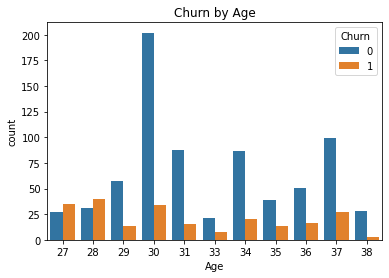

In [7]:
sns.countplot(data=df, x='Age', hue='Churn').set_title('Churn by Age');

It looks like younger customers (27-28y) tend to churn proportionally more often.

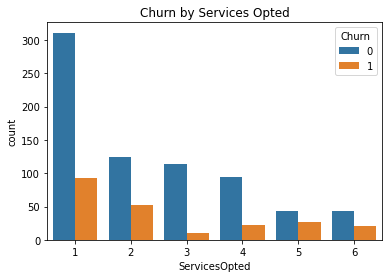

In [8]:
sns.countplot(data=df, x='ServicesOpted', hue='Churn').set_title('Churn by Services Opted');

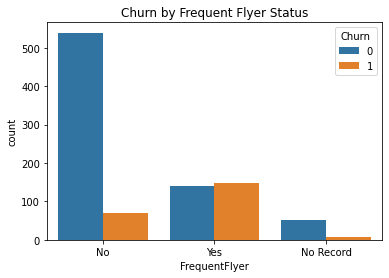

In [9]:
sns.countplot(data=df, x='FrequentFlyer', hue='Churn').set_title('Churn by Frequent Flyer Status');

It looks like frequent flyers churn more than non-frequent flyers. 

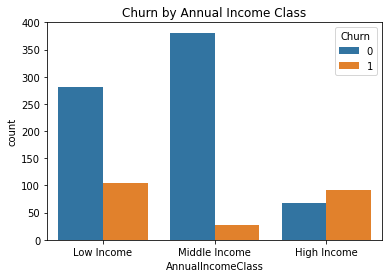

In [10]:
sns.countplot(data=df, x='AnnualIncomeClass', order=['Low Income','Middle Income','High Income'], hue='Churn').set_title('Churn by Annual Income Class');

It appears that high income individuals churn more than low and middle income classes.

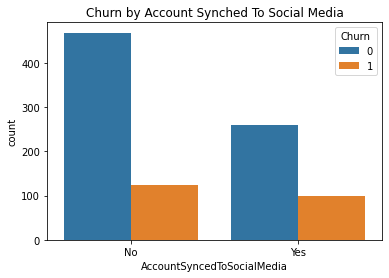

In [11]:
sns.countplot(data=df, x='AccountSyncedToSocialMedia', hue='Churn').set_title('Churn by Account Synched To Social Media');

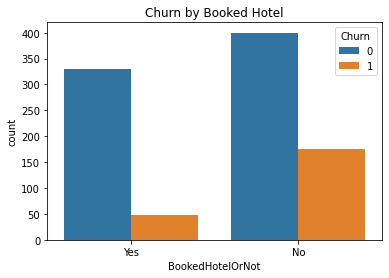

In [12]:
sns.countplot(data=df, x='BookedHotelOrNot', hue='Churn').set_title('Churn by Booked Hotel'); 


# Data pre-processing

In [13]:
df.isnull().sum()

Age                           0
FrequentFlyer                 0
AnnualIncomeClass             0
ServicesOpted                 0
AccountSyncedToSocialMedia    0
BookedHotelOrNot              0
Churn                         0
dtype: int64

There are no missing data

In [14]:
# create copy for encoding
df_coded = df.copy()

In [15]:
# Label Encoding ordinal features for services 
ordinals = ['ServicesOpted']
df_coded[ordinals] = df_coded[ordinals].apply(LabelEncoder().fit_transform)

In [16]:
# manually adapt scaling for Annual Income Class as we need to implement the ordinal scale in order to get correct scaling
df_coded = df_coded.replace({'AnnualIncomeClass': {'Low Income': 0, 'Middle Income': 1, 'High Income': 2}})

In [17]:
# One-Hot Encoding non-ordinal features
dummies = ['BookedHotelOrNot', 'AccountSyncedToSocialMedia', 'FrequentFlyer']
df_coded = pd.get_dummies(df_coded, columns = dummies, drop_first=True)

In [18]:
#rename some cols for clarity
df_coded.rename(columns={'BookedHotelOrNot_Yes':'BookedHotel', 'AccountSyncedToSocialMedia_Yes':'AccountSyncedToSocialMedia'}, inplace=True)

In [19]:
df_coded.head(6)

,Age,AnnualIncomeClass,ServicesOpted,Churn,BookedHotel,AccountSyncedToSocialMedia,FrequentFlyer_No Record,FrequentFlyer_Yes
0,34,1,5,0,1,0,0,0
1,34,0,4,1,0,1,0,1
2,37,1,2,0,0,1,0,0
3,30,1,1,0,0,0,0,0
4,30,0,0,0,0,0,0,0
5,27,2,0,1,1,0,0,1


Correlation matrix to explore relationships between variables.  

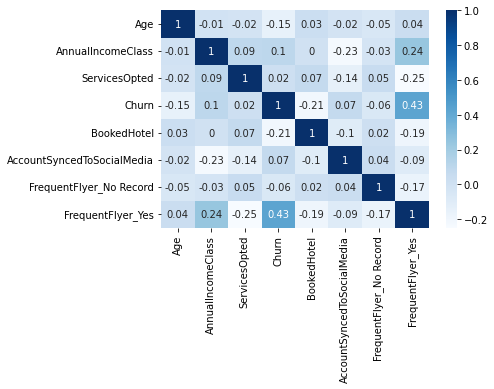

In [20]:
sns.heatmap(np.round(df_coded.corr(method ='spearman'), 2), annot=True,  cmap='Blues');

Even though the correlation matrix needs to be interpreted with caution (as it's based on scaled variables, which is also why Spearman's correlation is used), it gives some indication that e.g. annual income class and frequent flyer status are correlated. This also indicates that frequent flyers are associated with churning. 

# Model Creation and Evaluation

Split the data into training set and test set:

In [21]:
X = df_coded.drop(columns='Churn', axis=1)
y = df_coded['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [22]:
# Generic function to fit data and display results/predictions
def fit_evaluate(clf, X_train, X_test, y_train, y_test):
    # fit model to training data
    clf.fit(X_train, y_train)
    # make predictions for test data
    y_pred = clf.predict(X_test)
    # print evaluation
    print(classification_report(y_test, y_pred))
    print('\nConfusion Matrix: \n')
    s = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g', cmap='YlGnBu');
    s.set(xlabel='Predicted class', ylabel='True class')

Note: unbalanced data is not optimal for machine learning. Here I want to test some classic algorithms but also explore some classifiers that specifically account for unbalanced data (using imlearn).   

* Logistic regression * 

              precision    recall  f1-score   support

           0       0.83      0.94      0.88       240
           1       0.65      0.37      0.47        75

    accuracy                           0.80       315
   macro avg       0.74      0.66      0.68       315
weighted avg       0.79      0.80      0.78       315


Confusion Matrix: 



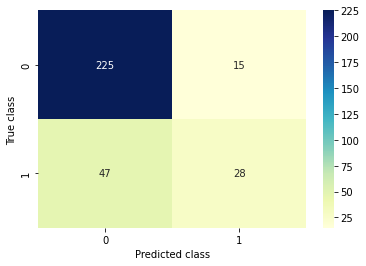

In [23]:
modelLR = LogisticRegression()
print('* Logistic regression * \n')
fit_evaluate(modelLR, X_train, X_test, y_train, y_test)

* Logistic regression * 

              precision    recall  f1-score   support

           0       0.91      0.76      0.83       240
           1       0.50      0.76      0.60        75

    accuracy                           0.76       315
   macro avg       0.70      0.76      0.71       315
weighted avg       0.81      0.76      0.77       315


Confusion Matrix: 



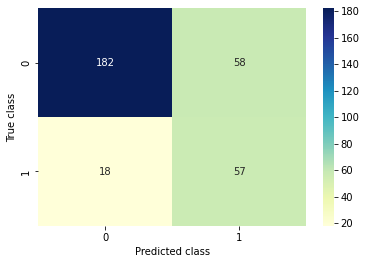

In [24]:
modelLR = LogisticRegression(class_weight='balanced')
print('* Logistic regression * \n')
fit_evaluate(modelLR, X_train, X_test, y_train, y_test)

Balancing the classes does not substantially improve the model. The prediction of the minority class gets better (at a cost of the majority class), as the model gets penalized more for errors in the minority class. 

* Random Forest Classifier * 

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       240
           1       0.77      0.68      0.72        75

    accuracy                           0.88       315
   macro avg       0.84      0.81      0.82       315
weighted avg       0.87      0.88      0.87       315


Confusion Matrix: 



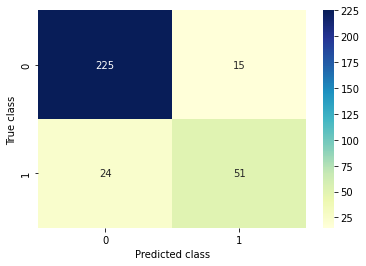

In [25]:
modelRF = RandomForestClassifier()
print('* Random Forest Classifier * \n')
fit_evaluate(modelRF, X_train, X_test, y_train, y_test)

The random forest classifier performs overall better than logistic regression. Next, testing if balancing the data improves the performance, particularly for the underrepresented class 1 (churned) using a balanced random forest classifier that randomly under-samples each boostrap sample to balance it.

* Balanced Random Forest Classifier * 

              precision    recall  f1-score   support

           0       0.96      0.85      0.90       240
           1       0.65      0.89      0.75        75

    accuracy                           0.86       315
   macro avg       0.81      0.87      0.83       315
weighted avg       0.89      0.86      0.87       315


Confusion Matrix: 



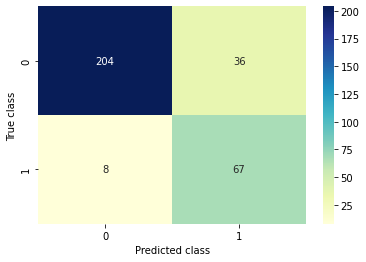

In [26]:
modelRF_bal = BalancedRandomForestClassifier()
print('* Balanced Random Forest Classifier * \n')
fit_evaluate(modelRF_bal, X_train, X_test, y_train, y_test)

The balanced random forest classifier classifies the minority class often correctly, however, at the cost of many false negatives. This shows that downsampling favors class 1, compared to other models.    

* Gradient Boosting Classifier * 

              precision    recall  f1-score   support

           0       0.91      0.94      0.93       240
           1       0.79      0.72      0.76        75

    accuracy                           0.89       315
   macro avg       0.85      0.83      0.84       315
weighted avg       0.89      0.89      0.89       315


Confusion Matrix: 



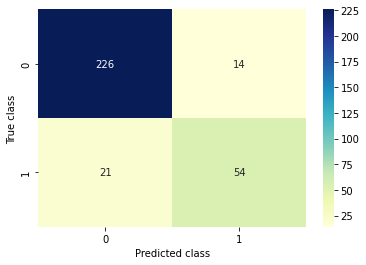

In [27]:
modelGB = GradientBoostingClassifier()
print('* Gradient Boosting Classifier * \n')
fit_evaluate(modelGB, X_train, X_test, y_train, y_test)

The GB classifier performs quite well. Next, testing a bagging classifier with additional balancing. The bagging approach randomly selects a subset of data to build several estimators. The base estimator is a decision tree.

* Balanced Bagging Classifier * 

              precision    recall  f1-score   support

           0       0.95      0.90      0.93       240
           1       0.73      0.85      0.79        75

    accuracy                           0.89       315
   macro avg       0.84      0.88      0.86       315
weighted avg       0.90      0.89      0.89       315


Confusion Matrix: 



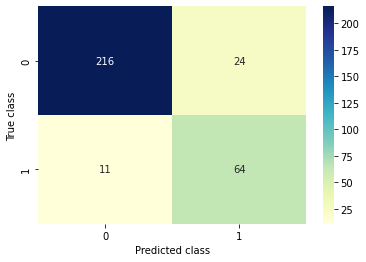

In [28]:
modelBBC = BalancedBaggingClassifier()
print('* Balanced Bagging Classifier * \n')
fit_evaluate(modelBBC, X_train, X_test, y_train, y_test)

As expected, the balanced bagging classifier also favors the underrepresented class 1 (churned), providing the best f1-value for the minority class and an overall good accuracy of 90%. 

* K Nearest Neighbors Classifier * 

              precision    recall  f1-score   support

           0       0.89      0.95      0.92       240
           1       0.80      0.64      0.71        75

    accuracy                           0.88       315
   macro avg       0.85      0.79      0.82       315
weighted avg       0.87      0.88      0.87       315


Confusion Matrix: 



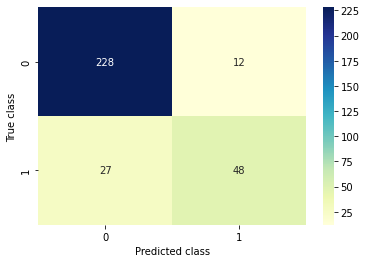

In [29]:
modelKNN = KNeighborsClassifier() 
print('* K Nearest Neighbors Classifier * \n')
fit_evaluate(modelKNN, X_train, X_test, y_train, y_test)

Minimum error: 0.124 at K = 5 



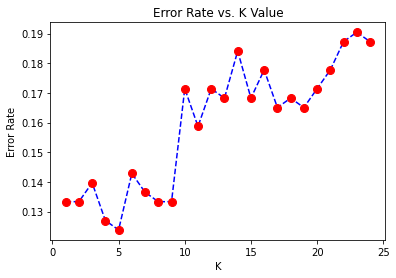

In [30]:
# finding the best k 
error_rate = []
for i in range(1,25):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

plt.plot(range(1,25), error_rate, color='b', linestyle='--', marker='o', markerfacecolor='r', markeredgecolor='r', markersize=8)
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.title('Error Rate vs. K Value')

# plotting the k value that minimizes the error 
print('Minimum error:', np.round(min(error_rate), 3),'at K =', (error_rate.index(min(error_rate)) + 1), '\n');

As the default for k is 5 already in KNN, the best k is already implemented in the default KNN above. 